### Problem definition

На проекте, где пользователь может отправить лайк другому пользователю, для увеличения количества лайков провели тест на замену сердца на галочку. При нажатии на крестик пользователю предлагается следующий пользователь. Тестовый вариант внедрили на пользователях с нечетным sender_id 24 марта в 16:00, на четных пользователях оставили базовый вариант.

**Вопрос**

Нужно ли внедрить нововведение для всех или отклонить его?
Подкрепите выводы графиками

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

pd.options.display.max_rows = 50
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
plt.style.use('classic')

In [2]:
# PATH TO FILE
PATH = '../files/Test_4.csv'

In [3]:
# load data
df = pd.read_csv(PATH,sep=";")
df.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


In [4]:
# check for dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768439 entries, 0 to 768438
Data columns (total 5 columns):
sender_id      768439 non-null int64
platform_id    768439 non-null int64
time_stamp     768439 non-null object
gender         768439 non-null object
reg_date       768439 non-null object
dtypes: int64(2), object(3)
memory usage: 29.3+ MB


После проверки типов данных видно, что некоторые колонки необходимо конвертировать в соответствующий тип, например timestamp и date -> datetime

In [5]:
# check for nulls
df.isnull().sum()

sender_id      0
platform_id    0
time_stamp     0
gender         0
reg_date       0
dtype: int64

На данном этапе null значений не найдено, будем искать дальше

Конвертируем time_stamp и reg_date в datetime тип

In [341]:
# type casting
df['time_stamp'] = df['time_stamp'].apply(pd.to_datetime)
df['event_date'] = df['time_stamp'].dt.date
df['reg_date'] = df['reg_date'].apply(pd.to_datetime)

Создаем поле с группой, в которую входит пользователь и немного приукрасим поле platform_id для читабельности 

In [7]:
# create a column with ab test group
df['group'] = df['sender_id'].apply(lambda val: val % 2).map({0:'Original',1:"Variant_A"})

# cast platform id values to readable name
df['platform_id'] = df['platform_id'].map({6:'desktop',7:'mobileApp'})

Проверим распределение пользователей в каждой группе теста в зависимости от пола и устройства.Для более точной валидации теста - распределения в обеих группах теста должны быть "примерно" равны

In [8]:
# check samples distribution
df['group'].value_counts()

Original     385684
Variant_A    382755
Name: group, dtype: int64

In [9]:
# check platform distribution
df['platform_id'].value_counts()

desktop      446092
mobileApp    322347
Name: platform_id, dtype: int64

In [10]:
# check platform distribution
df['gender'].value_counts()

m    659569
f    108699
        171
Name: gender, dtype: int64

Есть назначительное количество неизвестных значений, я заполню их самыми частыми значениями

In [11]:
# filling na values
most_common_gender = df['gender'].value_counts().index[0]
df['gender'] = df['gender'].replace(" ",np.nan).fillna(most_common_gender)

In [12]:
df.groupby(['platform_id','gender','group'])[['sender_id']].nunique()

sender_id
platform_id gender group               
desktop     f      Original        1624
                   Variant_A       1512
            m      Original        4544
                   Variant_A       4520
mobileApp   f      Original        1761
                   Variant_A       1678
            m      Original        5636
                   Variant_A       5602

Видно, что в каждой группе находится примерно одинаковое кол-во пользователей, что ОК

### Day-level segmentation

In [14]:
aggfuncs = {
    'sender_id': {
        'total_users':pd.Series.nunique,
        'total_likes':'count'
    }
}

In [15]:
df_agg1 = df.groupby(['event_date','group']).agg(aggfuncs)
df_agg1 = df_agg1.droplevel(level=0, axis=1).reset_index()
df_agg1['avg_likes'] = df_agg1['total_likes'] / df_agg1['total_users']

In [39]:
df_pivoted1 = df_agg1.pivot('event_date','group','avg_likes')

In [40]:
df_pivoted1

group,Original,Variant_A
event_date,,
2017-03-13,16.340426,20.750110
2017-03-14,16.270210,15.176788
2017-03-15,15.234389,13.893013
2017-03-16,15.313734,15.445005
2017-03-17,13.478327,13.952213
2017-03-18,11.461053,12.520468
2017-03-19,12.167039,11.823845
2017-03-20,13.006876,13.488631
2017-03-21,11.996979,11.272594


13 и 27 марта будут исключены из теста, т.к. 13 марта содержит подозрительно большое кол-во лайков на пользователя, а 27 - данные только по 1 пользователю и только по одной ветке

Text(0.5, 1.0, 'avg likes per user TS')

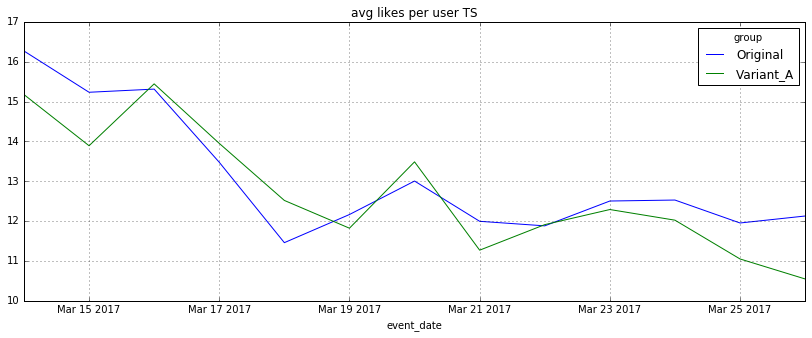

In [358]:
df_pivoted1.sort_index()[1:-1].plot(figsize=(14, 5), grid=True,).set_title('avg likes per user TS')

Ввиду того, что на данном этапе мы пытаемся делать выводы по двум переменным размером всего 13 объектов (дней - в данном примере) - использование каких-либо статистических тестов не целесообразно.

После визуального анализа распределений по среднему кол-ву лайков на юзера на дату теста -  я бы не утверждал, что есть какие либо отличия в группах эксперимента - обе ветки ведут себя одинаково, за исключением каких то конкретных дней. Например, при дате старта эксперимента - ветка Variant_A показала большое количество лайков на пользователя, но потом динамика выровнялась с Original. Нужно сегментировать данные по полу и девайсу - возможно, там можно будет наглядно заметить какую-либо разницу в группах.

Проверим как ведут себя пользователи в зависимости от гендера

In [360]:
df_agg2 = df.groupby(['event_date','group','gender']).agg(aggfuncs)
df_agg2 = df_agg2.droplevel(level=0, axis=1).reset_index()

df_agg2['group_gender'] = df_agg2['group']+"_"+df_agg2['gender']
df_agg2['avg_likes'] = df_agg2['total_likes'] / df_agg2['total_users']

df_pivoted2 = df_agg2.pivot('event_date','group_gender','avg_likes')[1:-1]

Text(0.5, 1.0, 'FEMALES - avg likes per user TS')

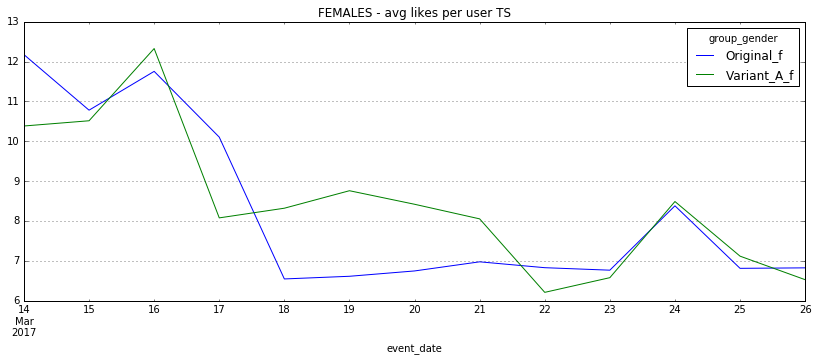

In [361]:
df_pivoted2.loc[:,['Original_f','Variant_A_f']].sort_index().plot(figsize=(14, 5), grid=True,).set_title('FEMALES - avg likes per user TS')

Text(0.5, 1.0, 'MALES - avg likes per user TS')

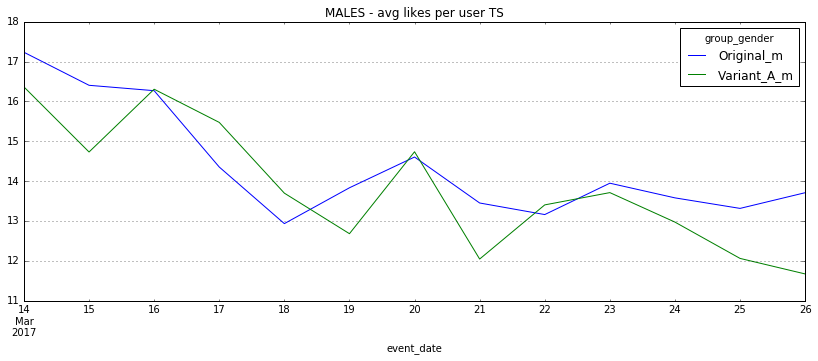

In [362]:
df_pivoted2.loc[:,['Original_m','Variant_A_m']].sort_index().plot(figsize=(14, 5), grid=True,).set_title('MALES - avg likes per user TS')

После визуального анализа нет значимых различий в ветках для женщин. Но что касается мужчин - видно что Original ветка лучше работает для мужчин.

Далее посмотри на устройство.

In [364]:
df_agg3 = df.groupby(['event_date','group','platform_id']).agg(aggfuncs)
df_agg3 = df_agg3.droplevel(level=0, axis=1).reset_index()

df_agg3['group_gender'] = df_agg3['group']+"_"+df_agg3['platform_id']
df_agg3['avg_likes'] = df_agg3['total_likes'] / df_agg3['total_users']

df_pivoted3 = df_agg3.pivot('event_date','group_gender','avg_likes')[1:-1]

Text(0.5, 1.0, 'Desktop - avg likes per user TS')

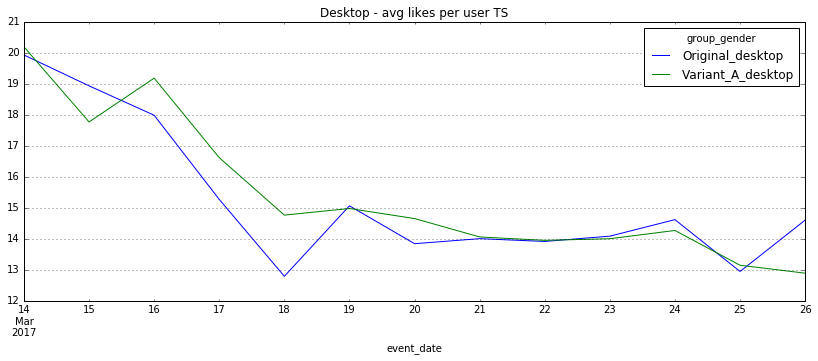

In [365]:
df_pivoted3.loc[:,['Original_desktop','Variant_A_desktop']].sort_index().plot(figsize=(14, 5), grid=True,).set_title('Desktop - avg likes per user TS')

Text(0.5, 1.0, 'MobileApp - avg likes per user TS')

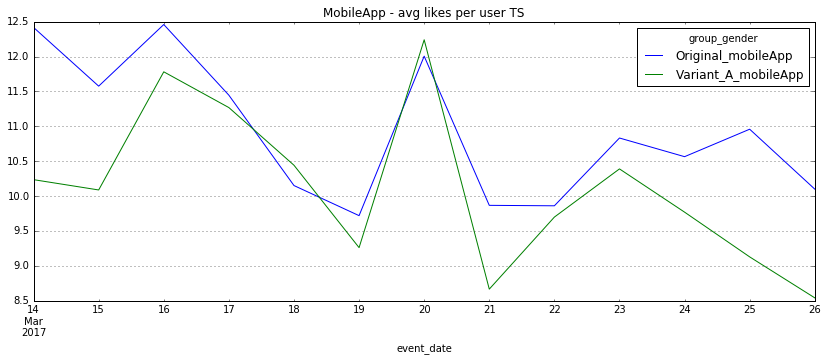

In [366]:
df_pivoted3.loc[:,['Original_mobileApp','Variant_A_mobileApp']].sort_index().plot(figsize=(14, 5), grid=True,).set_title('MobileApp - avg likes per user TS')

После визуального анализа устройств нет значимых различий в ветках десктоп,т.е. две ветки показывают одинаковую динамику, но для мобайл-апп - видно, что Original лучше перфомрит нежели альтернатива.

In [367]:
df_agg3 = df.groupby(['event_date','group','gender','platform_id']).agg(aggfuncs)
df_agg3 = df_agg3.droplevel(level=0, axis=1).reset_index()

df_agg3['group_gender_platf'] = df_agg3['group']+"_"+df_agg3['gender']+"_"+df_agg3['platform_id']
df_agg3['avg_likes'] = df_agg3['total_likes'] / df_agg3['total_users']

df_pivoted3 = df_agg3.pivot('event_date','group_gender_platf','avg_likes')[1:-1]

Text(0.5, 1.0, 'MobileAppMale - avg likes per user TS')

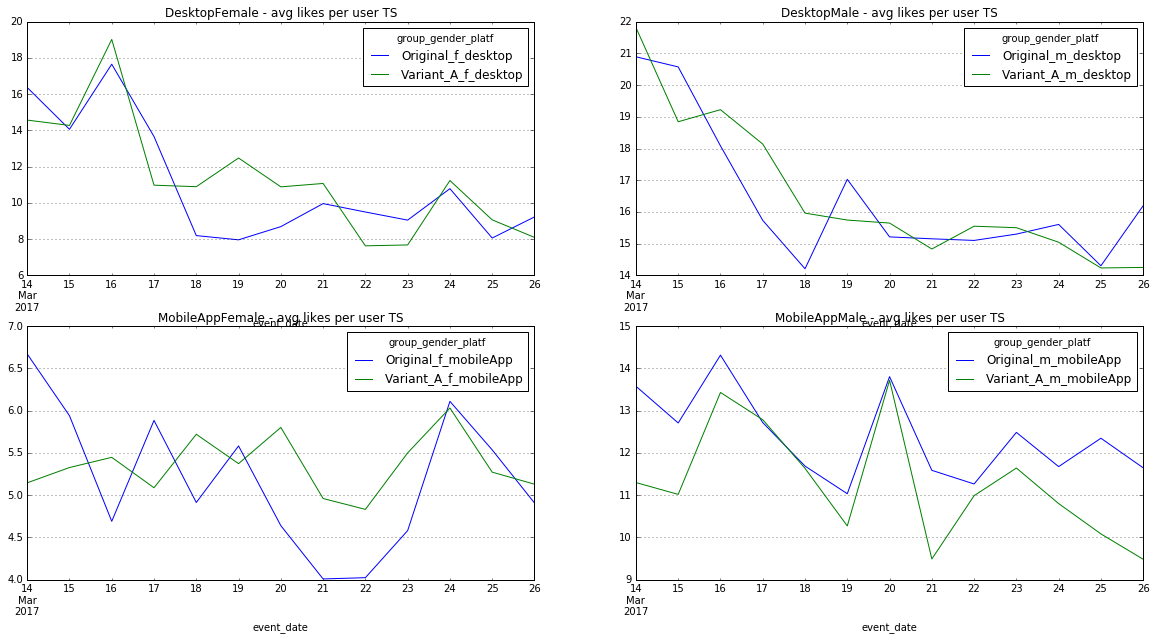

In [368]:
fig,ax = plt.subplots(2,2,figsize = (20,10))
df_pivoted3.loc[:,['Original_f_desktop','Variant_A_f_desktop']].sort_index().plot(ax=ax[0][0], grid=True,).set_title('DesktopFemale - avg likes per user TS')
df_pivoted3.loc[:,['Original_m_desktop','Variant_A_m_desktop']].sort_index().plot(ax=ax[0][1], grid=True,).set_title('DesktopMale - avg likes per user TS')
df_pivoted3.loc[:,['Original_f_mobileApp','Variant_A_f_mobileApp']].sort_index().plot(ax=ax[1][0], grid=True,).set_title('MobileAppFemale - avg likes per user TS')
df_pivoted3.loc[:,['Original_m_mobileApp','Variant_A_m_mobileApp']].sort_index().plot(ax=ax[1][1], grid=True,).set_title('MobileAppMale - avg likes per user TS')

Если обратить внимание на график MobileAppFemale - avg likes per user TS - можно наблюдать, что альтернативный вариант немного лучше перформит на мобильных приложениях, которыми пользуются женщины, но скорей всего такой резкий упадок активности в ветке Original для пользователей мобильного приложения женского пола вызван каким то внешним фактором. 

### User level segmentation

Спустимся на уровень пользователей, попробуем найти какие-то значимые различия в группах.

Посчитаем медиану дневных лайков на каждого юзера и для каждого юзера атрибутим его группу теста и пол.

In [474]:
# calculate median of daily likes per user
users_median_likes = df[df['time_stamp'].between('2017-03-14','2017-03-26',inclusive=True)]\
.groupby(['sender_id','event_date'])[['platform_id']].count().reset_index().groupby('sender_id')[['platform_id']].median().reset_index()

# get group and gender
users_median_likes = users_median_likes.merge(df[['sender_id','group','gender']].drop_duplicates(), on =['sender_id'])

Также необходимо добавить платформу, но как быть если пользователь лайкал на разных устройствах? Для удобства - я буду считать что предпочитаемое устройство - то, которым пользователь больше всего налайкал. Таким образом мы конечно же внесем погрешность в анализ, но это позволит нам более детально проанализировать данные.

In [476]:
# get prefered device
attr_platforms = pd.crosstab(
    df['sender_id'],
    df['platform_id'],
    df['platform_id'], 
    aggfunc = 'count', 
    normalize='index')
attr_platforms['prefered_device'] = attr_platforms.idxmax(axis=1)
attr_platforms.reset_index(inplace = True)

In [479]:
# putting it all together
df_combine = users_median_likes.merge(attr_platforms[['sender_id','prefered_device']],on = ['sender_id'],how='inner')
df_combine.rename(columns={'platform_id':'likes_per_user'},inplace=True)

In [481]:
df_combine.groupby('group')[['likes_per_user']].describe()

likes_per_user                                                  
                   count      mean        std  min  25%  50%   75%     max
group                                                                     
Original         11717.0  9.459845  23.434855  1.0  1.0  3.5  10.0   876.0
Variant_A        11548.0  9.254200  25.021467  1.0  1.0  3.0  10.0  2028.0

Видно что в алтернативном варианте - есть очень хардовые пользователи которые в перспективе могут исказить статистику. Также, если сравнивать среднее значения в каждой группе - они одинаковые, медианы - практически идентичны. На текущем этапе делаем предположение что оба варианта идентичны вне зависимости от страт которые в них входят, но различия могут быть внутри какой то стратифицированной выборке.

Я применю фильтр, который отсеет пользователей по 90 персентилю переменной среднего количества лайков на пользователя.

In [482]:
critical_value = df_combine[['likes_per_user']].quantile(.90)[0]

In [483]:
users_to_drop = df_combine[df_combine['likes_per_user'] >= critical_value].index
df_combine.drop(users_to_drop,axis = 0,inplace = True)

Построим графики распределения для каждой подгруппы и попробуем сделать выводы. Для удобства визуализации я буду использовать функцию для подсчета эмпирического кумулятивного распределения переменной.

In [484]:
# for distribution's plotting - empirical cumulative distribution 
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

Сравним распределения среднего кол-ва лайков в группах теста с помощью эмпирического кумулятивного распределения. Лично для меня - это удобный и легко интерпретируемый способ визуализации при сравнении двух непрерывных величин.

Text(0, 0.5, 'ecdf')

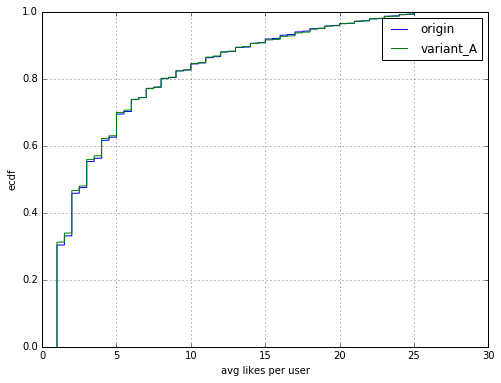

In [485]:
x_origin, y_origin = ecdf(df_combine.query('group == "Original"')['likes_per_user'])
x_var1, y_var1 = ecdf(df_combine.query('group == "Variant_A"')['likes_per_user'])

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_origin,y_origin,label='origin')
ax.plot(x_var1,y_var1,label='variant_A')
ax.legend()
ax.grid()
ax.set_xlabel('avg likes per user')
ax.set_ylabel('ecdf')

Видно что обе переменные не распределены нормально (я не буду использовать критерий Шапиро-Уилка в данном анализе что бы не залазить в статистические дебри), поэтому я буду использовать непараметрические тесты, а именно KS-тест Колмогорова-Смирнова, а именно two-sided тест, т.е. гипотеза предполагает что различий между ветками экперимента не наблюдаються.

Нулевая гипотеза будет звучать как две случайные непрерывные переменные были выбраны из одинакового непрерывного распределения вероятностей. Альтернитивная же - две случайные непрерывные переменные были взяты из разных распределений. Приемлемый уровень значимости - p_value < 0.05 

In [540]:
from scipy.stats.mstats import ks_twosamp

In [550]:
KS, pval = ks_twosamp(
    x_origin,
    x_var1, 
    alternative='two-sided')
print(f'P-value for KS test {pval:.3f}')

P-value for KS test 0.295


Как ранее предпологалось - оба варианта имеют практически идентичные распределения.

Попробуем посмотреть глубже сегментировав данные и проверить гипотезы на разность переменных внутри пола и устройства и пола+устройства.

## Gender

Итак - посмотрим на распределение среднего кол-ва дневных лайков на пользователя внутри гендер-группы. Сперва проанализируем женщин.

Text(0, 0.5, 'ecdf')

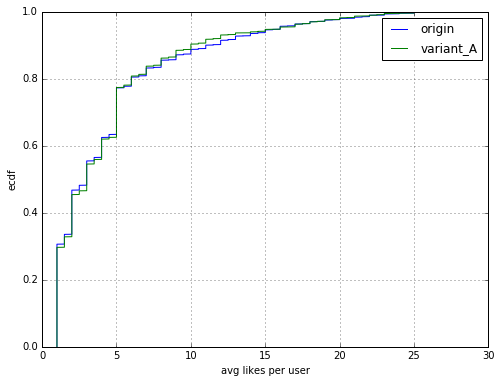

In [542]:
x_origin, y_origin = ecdf(df_combine.query('(group == "Original") & (gender == "f")')['likes_per_user'])
x_var1, y_var1 = ecdf(df_combine.query('(group == "Variant_A") & (gender == "f")')['likes_per_user'])

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_origin,y_origin,label='origin')
ax.plot(x_var1,y_var1,label='variant_A')
ax.legend()
ax.grid()
ax.set_xlabel('avg likes per user')
ax.set_ylabel('ecdf')

In [545]:
KS, pval = ks_twosamp(
    x_origin,
    x_var1, 
    alternative='two-sided')
print(f'P-value for KS test {pval:.3f}')

P-value for KS test 0.787


Уже ближе, но все равно нет статистически значимой разницы для женщин.
Далее - мужчины.

Text(0, 0.5, 'ecdf')

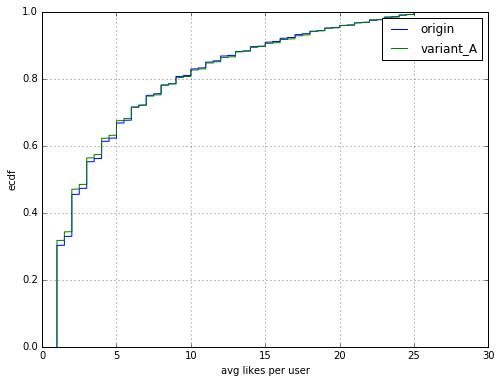

In [546]:
x_origin, y_origin = ecdf(df_combine.query('(group == "Original") & (gender == "m")')['likes_per_user'])
x_var1, y_var1 = ecdf(df_combine.query('(group == "Variant_A") & (gender == "m")')['likes_per_user'])

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_origin,y_origin,label='origin')
ax.plot(x_var1,y_var1,label='variant_A')
ax.legend()
ax.grid()
ax.set_xlabel('avg likes per user')
ax.set_ylabel('ecdf')

In [548]:
KS, pval = ks_twosamp(
    x_origin,
    x_var1, 
    alternative='two-sided')
print(f'P-value for KS test {pval:.3f}')

P-value for KS test 0.295


Аналогичная ситуация наблюдается и в группе мужчин, но мы куда более ближе приблизились к пороговому значению стат.значимости наших наблюдений.

## Platform

Теперь рассмотрим platform.

#### Desktop

Text(0, 0.5, 'ecdf')

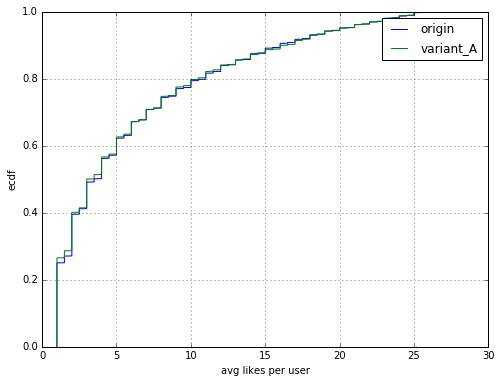

In [555]:
x_origin, y_origin = ecdf(df_combine.query('(group == "Original") & (prefered_device == "desktop")')['likes_per_user'])
x_var1, y_var1 = ecdf(df_combine.query('(group == "Variant_A") & (prefered_device == "desktop")')['likes_per_user'])

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_origin,y_origin,label='origin')
ax.plot(x_var1,y_var1,label='variant_A')
ax.legend()
ax.grid()
ax.set_xlabel('avg likes per user')
ax.set_ylabel('ecdf')

In [556]:
KS, pval = ks_twosamp(
    x_origin,
    x_var1, 
    alternative='two-sided')
print(f'P-value for KS test {pval:.3f}')

P-value for KS test 0.630


#### Mobile App

Text(0, 0.5, 'ecdf')

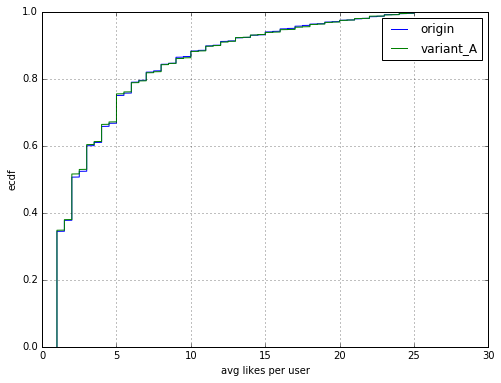

In [557]:
x_origin, y_origin = ecdf(df_combine.query('(group == "Original") & (prefered_device == "mobileApp")')['likes_per_user'])
x_var1, y_var1 = ecdf(df_combine.query('(group == "Variant_A") & (prefered_device == "mobileApp")')['likes_per_user'])

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_origin,y_origin,label='origin')
ax.plot(x_var1,y_var1,label='variant_A')
ax.legend()
ax.grid()
ax.set_xlabel('avg likes per user')
ax.set_ylabel('ecdf')

In [558]:
KS, pval = ks_twosamp(
    x_origin,
    x_var1, 
    alternative='two-sided')
print(f'P-value for KS test {pval:.3f}')

P-value for KS test 0.956


Как ранее утверждалось - различий внутри групп platform тоже не наблюдается.

### Platform + gender

Теперь проанализруем комбинации платформы и пола. Для этого создадим еще однин столбец в нашем датафреме - пол + платформа

In [562]:
df_combine['gender_device'] = df_combine['gender']+"_"+df_combine['prefered_device']

In [564]:
df_combine['gender_device'].value_counts()

m_mobileApp    8944
m_desktop      6662
f_mobileApp    2884
f_desktop      2387
Name: gender_device, dtype: int64

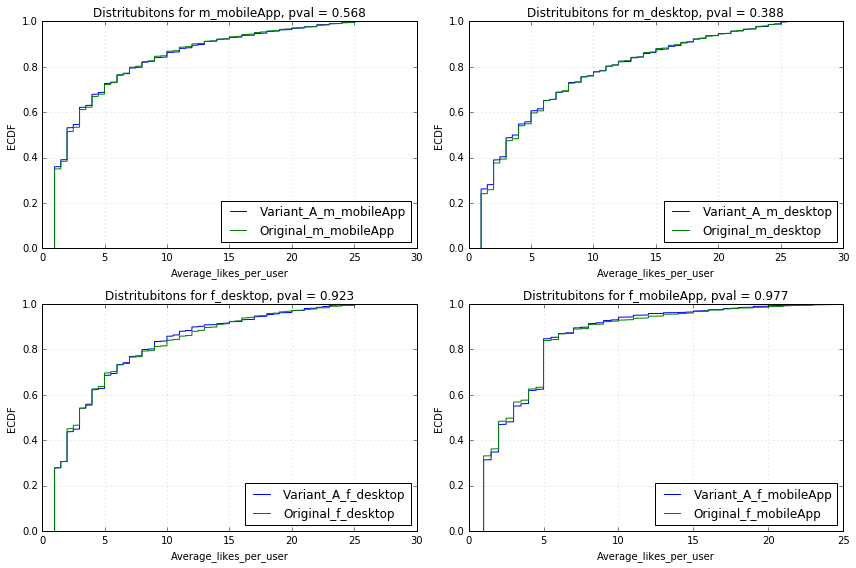

In [629]:
variants, subgroups = df_combine['group'].unique(), df_combine['gender_device'].unique()
f,ax = plt.subplots(2,2,figsize=(12,8))
ax = ax.ravel()

samples = []
for idx,i in enumerate(subgroups):
    for j in variants:
        mask_variant = (df_combine['group'] == j)
        mask_subgroup = (df_combine['gender_device'] == i)
        temp = df_combine[mask_variant & mask_subgroup]['likes_per_user']
        x_, y_ = ecdf(temp)
        if idx == idx_prev:
            KS,pval = ks_twosamp(x_,x_prev)
        ax[idx].plot(x_,y_,label = j+"_"+i)
        ax[idx].legend(loc='best')
        ax[idx].grid(alpha =0.3)
        ax[idx].set_xlabel('Average_likes_per_user')
        ax[idx].set_ylabel('ECDF')
        ax[idx].set_title(f'Distritubitons for {i}, pval = {pval:.3f}')
        plt.tight_layout()
        
        idx_prev = idx
        x_prev = x_
    

После анализа распределений внутри каждой ветки с применением комбининаций сегментов можно сделать вывод, что нет статистически значимой разницы в распределениях, т.е. оба варианта ведут себя одинаково.
Отвечая на вопрос можно ли внедрять изменения на всех пользователей или отклонить его - можно, но так как в обеих ветках нет значимых различий - экономически ли целесообразно это, т.к. внедрение может понести за собой дополнительных затрат, например время разработчиков.
Но хотелось бы еще вглянуть не только на тех пользователей которые лайкали, а те кто вообще видел окно с новым дизайном кнопки, тем самым померять конверсию в лайк от тех кто видел новую кнопку.
Так же хотелось бы посмотреть как себя ведут новые пользователи.